# Multinomial Naive Bayes

Multinomial Naive Bayes is favored to use on data that is multinomial distributed. It is widely used in text classification in NLP.  Each event in text classification constitutes the presence of a word in a document.

Reference: https://www.analyticssteps.com/blogs/what-naive-bayes-algorithm-machine-learning

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#!pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

### Load Data

In [2]:
# stop words removed
df = pd.read_csv("../data/review_2022_clean.csv")
df.head()

,text,label
0,bought fender telecaster salesperson told orig...,negative
1,visit son restaurant desert home food authenti...,positive
2,danielle great job listened cut hair way reque...,positive
3,saw lot roaches bathroom woke bed large dark s...,negative
4,ordered pork fried rice beef chow mei fun teri...,negative


In [3]:
df_sw = pd.read_csv("../data/review_2022_clean_sw.csv")
df_sw.head()

,text,label
0,i bought a fender telecaster that the salesper...,negative
1,this is our go to for take out when i visit my...,positive
2,danielle did a great job she listened and cut ...,positive
3,we saw a lot of roaches in the bathroom when w...,negative
4,we ordered pork fried rice and beef chow mei f...,negative


### Check Imbalanced Data

In [4]:
pd.DataFrame(df).label.value_counts()

positive    20916
negative     8566
neutral      2183
Name: label, dtype: int64

In [5]:
print("Imbalanced data in dataset:")
total = df.shape[0]
value_counts = pd.DataFrame(df).label.value_counts()
positive_percent = value_counts["positive"]/total*100
negative_percent = value_counts["negative"]/total*100
neutral_percent = value_counts["neutral"]/total*100

print("Postive - {:04.2f}".format(positive_percent)+'%')
print("Negative - {:04.2f}".format(negative_percent)+'%')
print("Neutral - {:04.2f}".format(neutral_percent)+'%')

Imbalanced data in dataset:
Postive - 66.05%
Negative - 27.05%
Neutral - 6.89%


<AxesSubplot:title={'center':'Class distribution'}, xlabel='label'>

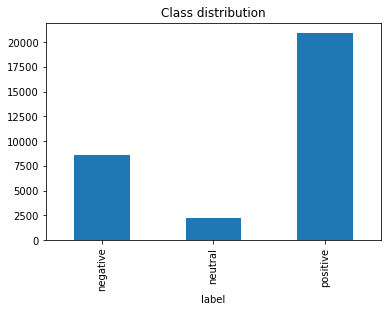

In [6]:
df.pivot_table(index='label', aggfunc='size').plot(kind='bar', title = 'Class distribution')

### Train-Test Split

In [7]:
def split(stop_words=False):
  if stop_words:
    X = df_sw["text"]
    y = df_sw["label"]
  else:
    X = df["text"]
    y = df["label"]
  return train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train, X_test, y_train, y_test = split()

In [9]:
X_train_sw, X_test_sw, y_train_sw, y_test_sw = split(stop_words=True)

<AxesSubplot:title={'center':'Class distribution'}, xlabel='label'>

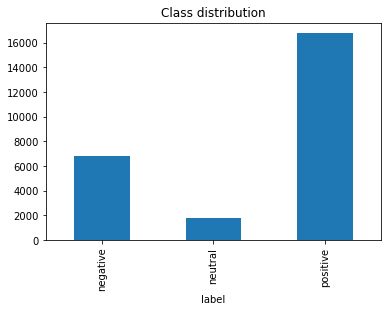

In [10]:
# check class distribution in train set
pd.DataFrame(y_train_sw).pivot_table(index='label', aggfunc='size').plot(kind='bar', title = 'Class distribution')

<AxesSubplot:title={'center':'Class distribution'}, xlabel='label'>

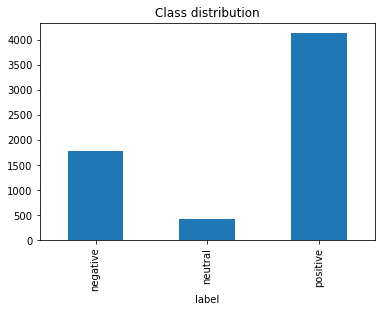

In [11]:
# check class distribution in test set
pd.DataFrame(y_test_sw).pivot_table(index='label', aggfunc='size').plot(kind='bar', title = 'Class distribution')

### Modelling

Hyperparameters:
1. alpha
- Setting α=1 is called Laplace smoothing, while α<1 is called Lidstone smoothing. 0 for no smoothing.
- Smoothing parameter α =1. Add 1 to every probability, therefore the probability will never be zero
(https://medium.com/syncedreview/applying-multinomial-naive-bayes-to-nlp-problems-a-practical-explanation-4f5271768ebf#:~:text=A%20small%2Dsample%20correction%2C%20or,is%20often%20called%20Lidstone%20smoothing%20.)

2. fit_prior -> default = True
- Whether to learn class prior probabilities or not. If false, a uniform prior will be used.

3. class_prior -> default = None
- Prior probabilities of the classes. If specified, the priors are not adjusted according to the data.
- if default, each class prior = frequency of the class / total 

In [12]:
# Reference: https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7

def create_grid_search(ngram_range):
  tfidf = TfidfVectorizer(ngram_range=ngram_range)
  pipe = imbpipeline(steps = [['tfidf', tfidf],['smote', SMOTE(random_state=11)],['mnb', MultinomialNB()]])
  
  param_grid = {
    'mnb__alpha': [1, 0.1, 0.001],
    'mnb__fit_prior': [True, False],
    'mnb__class_prior': [None, [0.3,0.3,0.4],[0.4,0.3,0.3],[0.3,0.4,0.3],[0.3,0.5,0.2]]
    }
    
  search = GridSearchCV(pipe, param_grid, cv=10, scoring="accuracy", n_jobs=-1)
  return search

In [13]:
def train_evaluate(ngram_range, X_train, X_test, y_train, y_test, df_result, preprocessing, metric):
  search = create_grid_search(ngram_range)
  search.fit(X_train, y_train)

  print("Best Parameters:")
  print(search.best_params_)

  y_pred = search.predict(X_test)

  print("Classification Report:")
  print(classification_report(y_test, y_pred))

  print("Confusion Matrix:")
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.show()
    
  report = classification_report(y_test,y_pred,output_dict=True)
  result = pd.DataFrame(
    {
        "preprocessing":[preprocessing],
        f"{metric}_negative":report["negative"][f"{metric}"],
        f"{metric}_neutral":report["neutral"][f"{metric}"],
        f"{metric}_positive":report["positive"][f"{metric}"],
        f"{metric}_macro_avg":report["macro avg"][f"{metric}"],
        f"{metric}_weighted_avg":report["weighted avg"][f"{metric}"],
    }
    )

  df_result.append(result)

  return search

### Comparison of MultinomialNB with different preprocessing methods

In [14]:
df_result = []
metric = "f1-score"

##### Unigrams

Best Parameters:
{'mnb__alpha': 0.1, 'mnb__class_prior': [0.3, 0.3, 0.4], 'mnb__fit_prior': True}
Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.78      0.79      1770
     neutral       0.25      0.42      0.31       428
    positive       0.93      0.88      0.90      4135

    accuracy                           0.82      6333
   macro avg       0.66      0.69      0.67      6333
weighted avg       0.85      0.82      0.83      6333

Confusion Matrix:


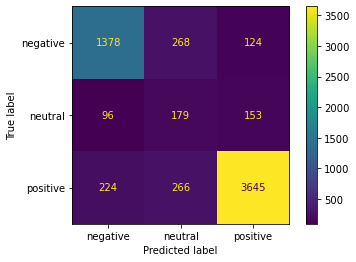

In [15]:
model_uni = train_evaluate((1, 1), X_train, X_test, y_train, y_test, df_result, "unigrams", metric)

##### Unigrams + Stop Words

Best Parameters:
{'mnb__alpha': 0.1, 'mnb__class_prior': [0.3, 0.3, 0.4], 'mnb__fit_prior': True}
Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.79      0.80      1770
     neutral       0.26      0.41      0.32       428
    positive       0.93      0.89      0.91      4135

    accuracy                           0.83      6333
   macro avg       0.67      0.70      0.68      6333
weighted avg       0.85      0.83      0.84      6333

Confusion Matrix:


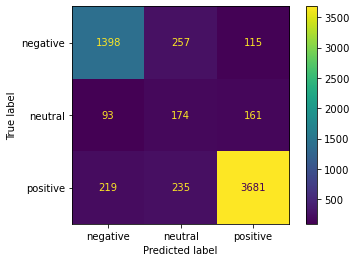

In [16]:
model_uni_sw = train_evaluate((1, 1), X_train_sw, X_test_sw, y_train_sw, y_test_sw, df_result, "unigrams_sw", metric)

##### Bigrams

Best Parameters:
{'mnb__alpha': 0.1, 'mnb__class_prior': [0.3, 0.3, 0.4], 'mnb__fit_prior': True}
Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.76      0.81      1770
     neutral       0.23      0.13      0.17       428
    positive       0.87      0.95      0.91      4135

    accuracy                           0.84      6333
   macro avg       0.66      0.61      0.63      6333
weighted avg       0.83      0.84      0.83      6333

Confusion Matrix:


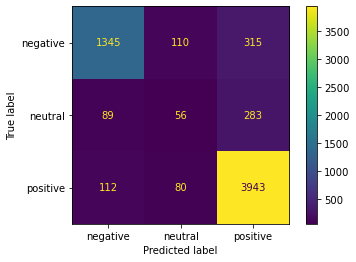

In [17]:
model_bi = train_evaluate((2, 2), X_train, X_test, y_train, y_test, df_result, "bigrams", metric)

##### Bigrams + Stop Words

Best Parameters:
{'mnb__alpha': 0.1, 'mnb__class_prior': [0.3, 0.3, 0.4], 'mnb__fit_prior': True}
Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.85      0.85      1770
     neutral       0.33      0.25      0.28       428
    positive       0.92      0.95      0.93      4135

    accuracy                           0.87      6333
   macro avg       0.70      0.68      0.69      6333
weighted avg       0.86      0.87      0.87      6333

Confusion Matrix:


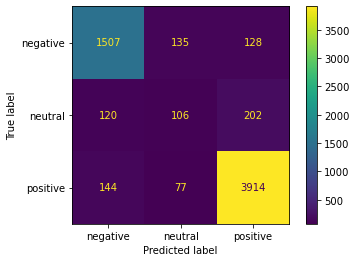

In [18]:
model_bi_sw = train_evaluate((2, 2), X_train_sw, X_test_sw, y_train_sw, y_test_sw, df_result, "bigrams_sw", metric)

##### Unigrams + Bigrams

Best Parameters:
{'mnb__alpha': 0.1, 'mnb__class_prior': [0.3, 0.3, 0.4], 'mnb__fit_prior': True}
Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.82      0.83      1770
     neutral       0.30      0.25      0.27       428
    positive       0.91      0.94      0.92      4135

    accuracy                           0.86      6333
   macro avg       0.69      0.67      0.68      6333
weighted avg       0.85      0.86      0.86      6333

Confusion Matrix:


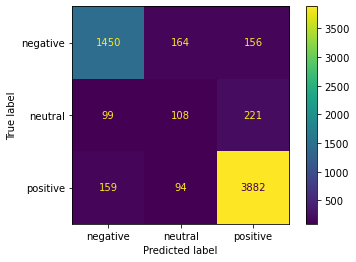

In [19]:
model_uni_bi = train_evaluate((1, 2), X_train, X_test, y_train, y_test, df_result, "unigrams_bigrams", metric)

##### Unigrams + Bigrams + Stop Words

Best Parameters:
{'mnb__alpha': 0.001, 'mnb__class_prior': [0.4, 0.3, 0.3], 'mnb__fit_prior': True}
Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.85      0.85      1770
     neutral       0.25      0.03      0.06       428
    positive       0.88      0.96      0.92      4135

    accuracy                           0.87      6333
   macro avg       0.66      0.61      0.61      6333
weighted avg       0.83      0.87      0.84      6333

Confusion Matrix:


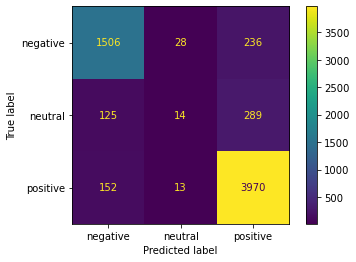

In [20]:
model_uni_bi_sw = train_evaluate((1, 2), X_train_sw, X_test_sw, y_train_sw, y_test_sw, df_result, "unigrams_bigrams_sw", metric)

## Findings

Preprocessing methods:
1. Unigrams
2. Unigrams + Stop Words
3. Bigrams
4. Bigrams + Stop Words
5. Unigrams + Bigrams
6. Unigrams + Bigrams + Stop Words

Evaluataion metric = f1-score
- Another way to solve class imbalance problems is to use better accuracy metrics like the F1 score, which take into account not only the number of prediction errors that your model makes, but that also look at the type of errors that are made.

Reference: https://towardsdatascience.com/the-f1-score-bec2bbc38aa6

macro avg or weighted avg
- In general, if you are working with an imbalanced dataset where all classes are equally important, using the macro average would be a good choice as it treats all classes equally.
- From business owner's perspective, false positive of label "positive" is better than false negative as it helps to attract customer. So weighted avg is more suitable.
- From reader's perspective, false positive of label "positive" is false positive review that brings misleading information to them. So macro average is more suitable.

Reference: https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f

Before hyperparameter tuning:
- negative f1-score = 0.30 ~ 0.76 (unigrams)
- neutral f1-score = 0.00
- positive f1-score = 0.81 ~ 0.88 (unigrams)
- w.avg f1-score = 0.61 ~ 0.79 (unigrams)

In [21]:
print("After hyperparameter tuning:")
result = pd.concat(df_result, axis=0).set_index("preprocessing").sort_values(by=f"{metric}_weighted_avg", ascending=False)
print(result)

After hyperparameter tuning:
                     f1-score_negative  f1-score_neutral  f1-score_positive  \
preprocessing                                                                 
bigrams_sw                    0.851172          0.284182           0.934240   
unigrams_bigrams              0.833813          0.272040           0.924946   
unigrams_bigrams_sw           0.847734          0.057971           0.920046   
unigrams_sw                   0.803448          0.318099           0.909787   
unigrams                      0.794694          0.313760           0.904803   
bigrams                       0.811218          0.166172           0.908944   

                     f1-score_macro_avg  f1-score_weighted_avg  
preprocessing                                                   
bigrams_sw                     0.689865               0.867091  
unigrams_bigrams               0.676933               0.855351  
unigrams_bigrams_sw            0.608584               0.841575  
unigrams_sw  

In [22]:
print("Best preprocessing method:")
w_avg = f"{metric}_weighted_avg"
print(f"{result.index[0]} with {metric} weighted avg score = {result.iloc[[0],4].values}")

Best preprocessing method:
bigrams_sw with f1-score weighted avg score = [0.86709116]


### Solving Imbalanced Data

Using best preprocessing method from above
- Undersampling
- Oversampling
- Data augmentation using SMOTE algorithm

Reference: https://towardsdatascience.com/smote-fdce2f605729

Note: Use accuracy as evaluation metric for balanced dataset (https://towardsdatascience.com/the-f1-score-bec2bbc38aa6)

##### Data augmentation using SMOTE algoritm

SMOTE is an intelligent alternative to oversampling: rather than creating duplicates of the minority class, it creates synthetic data points that are relatively similar to the original ones.

Using SMOTE, your model will start detecting more cases of the minority class, which will result in an increased recall, but a decreased precision. The decision of whether this is wanted behavior will always be depending on your business case.

In [23]:
# Reference: https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7

def create_grid_search(ngram_range):
  tfidf = TfidfVectorizer(ngram_range=ngram_range)
  pipe = imbpipeline(steps = [['tfidf', tfidf],['smote', SMOTE(random_state=11)],['mnb', MultinomialNB()]])
  
  param_grid = {
    'mnb__alpha': [1, 0.1, 0.001],
    'mnb__fit_prior': [True, False],
    'mnb__class_prior': [None, [0.3,0.3,0.4],[0.4,0.3,0.3],[0.3,0.4,0.3],[0.3,0.5,0.2]]
    }
    
  search = GridSearchCV(pipe, param_grid, cv=10, scoring="balanced_accuracy", n_jobs=-1)
  return search

Best Parameters:
{'mnb__alpha': 1, 'mnb__class_prior': [0.3, 0.3, 0.4], 'mnb__fit_prior': True}
Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.79      0.78      1770
     neutral       0.21      0.72      0.33       428
    positive       0.98      0.74      0.84      4135

    accuracy                           0.75      6333
   macro avg       0.66      0.75      0.65      6333
weighted avg       0.87      0.75      0.79      6333

Confusion Matrix:


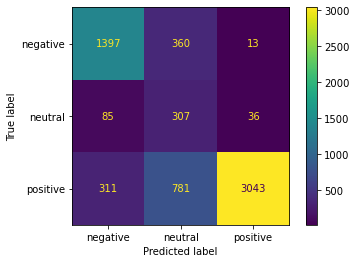

In [24]:
model_uni_bi_sw_smote = train_evaluate((1, 2), X_train_sw, X_test_sw, y_train_sw, y_test_sw, df_result, "unigrams_bigrams_sw_smote", metric)

In [25]:
print("Added smote:")
result = pd.concat(df_result, axis=0).set_index("preprocessing").sort_values(by=f"{metric}_weighted_avg", ascending=False)
print(result)

Added smote:
                           f1-score_negative  f1-score_neutral  \
preprocessing                                                    
unigrams_bigrams_sw                 0.837905          0.261874   
bigrams_sw                          0.833703          0.208505   
unigrams_bigrams                    0.818130          0.221402   
bigrams                             0.812100          0.195459   
unigrams_bigrams_sw_smote           0.784171          0.327292   
unigrams_sw                         0.773216          0.310788   
unigrams                            0.762650          0.290832   

                           f1-score_positive  f1-score_macro_avg  \
preprocessing                                                      
unigrams_bigrams_sw                 0.923653            0.674477   
bigrams_sw                          0.920158            0.654122   
unigrams_bigrams                    0.912403            0.650645   
bigrams                             0.902252        

### Sanity Check

Positive review?

In [26]:
model_uni_bi_sw.predict(["The food is great! Especially the unagi!"])

array(['positive'], dtype='<U8')

Negative review?

In [27]:
model_uni_bi_sw.predict(["The service sucks! I will never come back again!"])

array(['negative'], dtype='<U8')

Neutral review?

In [30]:
model_uni_bi_sw.predict(["The food is decent but the price is a bit high."])

array(['neutral'], dtype='<U8')

Sarcastic review?

In [31]:
model_uni_bi_sw.predict(["The food is so good that I think you need next level of taste buds to appreciate it."])

array(['positive'], dtype='<U8')

Spam review?

In [32]:
model_uni_bi_sw.predict(["Personal loan with low interest - call 0123456789."])

array(['negative'], dtype='<U8')

In [33]:
model_uni_bi_sw.predict(["Personal loan with quick approval - call 0123456789."])

array(['negative'], dtype='<U8')

Random text?

In [34]:
model_uni_bi_sw.predict(["Market is bullish."])

array(['neutral'], dtype='<U8')

In [35]:
model_uni_bi_sw.predict(["Market is bullish. Forgot what's the next part of the sentence already."])

array(['negative'], dtype='<U8')

Emoji?

In [36]:
model_uni_bi_sw.predict(["🙂🙂🙂"])

array(['neutral'], dtype='<U8')

In [37]:
model_uni_bi_sw.predict(["🤬🤬🤬"])

array(['neutral'], dtype='<U8')

In [38]:
model_uni_bi_sw.predict(["The atmosphere is not bad."])

array(['neutral'], dtype='<U8')

In [39]:
model_uni_bi_sw.predict(["The service is not nice."])

array(['negative'], dtype='<U8')

In [40]:
model_uni_bi_sw.predict(["The food is great but the service is lousy."])

array(['negative'], dtype='<U8')